
#  Modeling : Ensemble Climate Projections

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

We predict the ecological distribution of Xantusia vigilis, commonly known as the desert night lizard. The binary classes indicate presence and background, the latter of which a randomly drawn "pseudo absence" set. Train and test (80/20) sets included ten decorrelated BioClim features (1970-2000) extracted per location. We then predict a spatial output for the most predictive ML model, which turns out to be a tuned random forest model, performing the classification pixel by pixel across the climate raster layers. 

Research questions include: 


* How can models of climate change effects on geographic distributions incorporate symbiotic species relationships?
* What is the best quantification of uncertainty for climate forecasts in Southwest deserts?


### Comparing ML Classifiers with PyCaret and SKlearn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)|
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | C*100
|BioClim6| Min Temp Coldest Month| C
|BioClim7| Temp Annual Range| C
|BioClim8| Mean Temp Wettest Quareter | C
|BioClim9| Mean Temp Driest Quareter | C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

In [4]:
exec(open('/Users/danielfurman/Data_science_code/ML_sdms_train.py').read())

# Binary classification with ten BioClim features. Five are a function of precipitation and five of temperature, all
# decorrelated below a 0.5 correlation threshold. We use PyCaret to train and tune (10-fold cv) our models from a 
# train set that contains 80%  of the total data. 10-fold cross validation tuning was performed, yet for some models
# the default hyper-params performed best. 

Transformation Pipeline and Model Succesfully Saved
PyCaret training ended 




In [5]:
compare_models() # Default models compared by mean statistics from 10-fold CV

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9623,0.9920,0.9396,0.9130,0.9259,0.9006,0.9010,0.2583
1,CatBoost Classifier,0.9615,0.9897,0.9407,0.9092,0.9245,0.8987,0.8991,2.7327
2,Extreme Gradient Boosting,0.9601,0.9883,0.9396,0.9060,0.9221,0.8954,0.8960,0.3748
3,Light Gradient Boosting Machine,0.9599,0.9900,0.9386,0.9056,0.9214,0.8945,0.8951,0.1126
4,Random Forest Classifier,0.9531,0.9837,0.9041,0.9095,0.9062,0.8750,0.8755,0.1147
5,Gradient Boosting Classifier,0.9526,0.9844,0.9181,0.8959,0.9065,0.8748,0.8752,0.7745
6,Decision Tree Classifier,0.9477,0.9356,0.9116,0.8843,0.8973,0.8623,0.8629,0.0238
7,Ada Boost Classifier,0.9399,0.9806,0.8998,0.8661,0.8824,0.8421,0.8426,0.2271
8,K Neighbors Classifier,0.9340,0.9683,0.9235,0.8318,0.8751,0.8305,0.8327,0.0057
9,Logistic Regression,0.9286,0.9679,0.9030,0.8279,0.8636,0.8154,0.8170,0.0524


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7211, verbose=0,
                     warm_start=False)



Fraction correct validation Random Forest : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.9436201780415431


Fraction correct validation XGBoost : 0.9691032403918614
[[970  25]
 [ 16 316]]
The F1 validation score is :  0.9390787518573551


Fraction correct validation Extra Trees : 0.9713639788997739
[[972  23]
 [ 15 317]]
The F1 validation score is :  0.9434523809523809


Fraction correct validation LGBoost Machine : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.9436201780415431


Fraction correct validation Catboost : 0.9698568198944989
[[966  29]
 [ 11 321]]
The F1 validation score is :  0.9413489736070382


Fraction correct validation MLP neural-net : 0.9427279577995479
[[956  39]
 [ 37 295]]
The F1 validation score is :  0.8858858858858859


Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Blended model : 0.9653353428786737
[[969  26]
 [ 20 312]]
The F1 validation score is :  0.931343283582

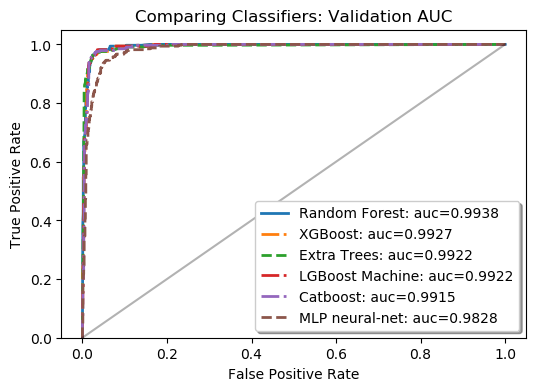

In [8]:
exec(open('/Users/danielfurman/Data_science_code/ML_sdms_predict.py').read())

# Now that we have trained and tuned our ML models, we are ready to predict the validation set and examine the ML
# performance. We first print the validation set (20% held out of training) accuracy, as well as the F statistic 
# and the 2x2 confusion matrix for Rforest, XGB, Etrees, Catboost, LGBM, and MLP-net models. We then visualize
# the AUC statistic with the ROC curve. We also examine the results of a blended PyCaret model. 

In [9]:
f_score # F-statistic for the models above, as well as the PyCaret blended model. We find Random Forest is the
# winner in terms of validation AUC and F-stat, as well as with 10-fold Prec. Extra trees performs second best when 
# considering 10-fold CV and validation performance. Both of these models are compatible with the R dismo package,
# and the next step is to copy their hyperparams into R for dismo's geospatial predict: see sdms_2020.R

,RForest,LGBM,Extra Trees,Catboost,XGBoost,Blended,MLP-net
F-statistic :,0.94362,0.94362,0.943452,0.941349,0.939079,0.931343,0.885886


### Geospatial Predictions of Distributions
---

In [101]:
exec(open('/Users/danielfurman/Downloads/pyimpute-master/src/pyimpute/_main_edited.py').read())
# updated pyimpute functions

In [110]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

explanatory_rasters = sorted(glob.glob('xantusia-data-main/train_tifs/bclim*.asc')) # grab filepath names
print('\nThere are', len(explanatory_rasters), '.asc features.')  
response_data = gpd.GeoDataFrame.from_file('xantusia-data-main/points_xv/points_xv.shp') 
# grab geojson of presences/absences
response_data.head(3)


There are 10 .asc features.


,longitude,latitude,pa,geometry
0,-118.527201,34.798079,1.0,POINT (-118.52720 34.79808)
1,-113.778800,37.167000,1.0,POINT (-113.77880 37.16700)
2,-118.123244,35.737211,1.0,POINT (-118.12324 35.73721)


In [15]:
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='pa')
#train_xs.shape, train_y.shape # check shape
target_xs, raster_info = load_targets(explanatory_rasters)
impute(target_xs, tuned_rf, raster_info, 
       outdir="/Users/danielfurman/Data_science_code/xantusia-data-main", 
       class_prob=True, certainty=True)

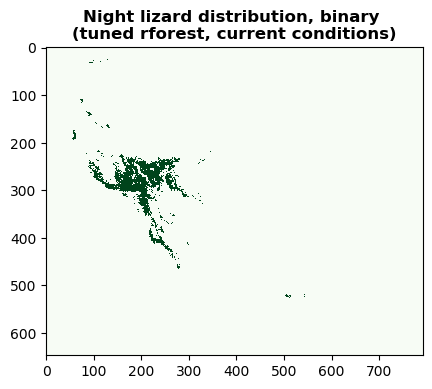

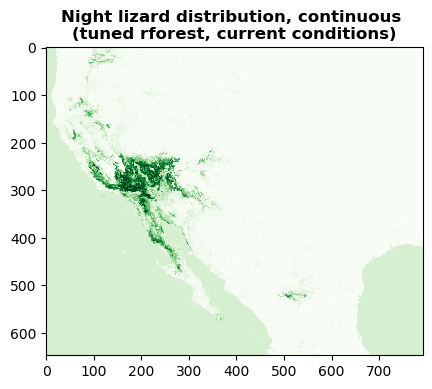

In [112]:
rf_curr = rasterio.open("xantusia-data-main/responses.tif") 
plt.imshow(rf_curr.read(1), cmap='Greens')
plt.title('Night lizard distribution, binary \n(tuned rforest, current conditions)', fontweight ='bold')
plt.figure()
rf_curr = rasterio.open("xantusia-data-main/probability_1.0.tif") 
plt.imshow(rf_curr.read(1), cmap = 'Greens')
plt.title('Night lizard distribution, continuous \n(tuned rforest, current conditions)', fontweight ='bold')
print('')